This notebook introduces the problem addressed in this paper:

 - localizating an object in a large image
 - foveation
 - action (saccade)
 

In [1]:
%run 0_parameters.ipynb


This notebook introduces the problem addressed in this paper:

 - localizating an object in a large image
 - foveation
 - action (saccade)
       
      
2019-03-13
{'minibatch_size': 1, 'test_batch_size': 1000, 'cmin': 0.1307, 'cmax': 0.3081, 'N_pic': 128, 'offset_std': 30, 'offset_max': 35, 'noise': 1.0, 'contrast': 0.4, 'sf_0': 0.2, 'B_sf': 0.3, 'N_theta': 6, 'N_azimuth': 16, 'N_eccentricity': 10, 'N_phase': 2, 'N_X': 128, 'N_Y': 128, 'rho': 1.41, 'bias_deconv': True, 'dim1': 1000, 'dim2': 1000, 'loss_func': BCEWithLogitsLoss(), 'lr': 0.0001, 'do_adam': False, 'epochs': 1, 'momentum': 0.05, 'n_epochs': 10, 'num_processes': 1, 'no_cuda': True, 'log_interval': 0, 'verbose': 1, 'filename': '../data/2019-03-13', 'seed': 2019}


In [2]:
figname = '../paper/fig_result'

# Definition of the input and the output 

## Representation of input image (retina)

In [3]:
from retina import Display
d = Display(args)

In [4]:
from retina import Retina
r = Retina(args)

In [5]:
data, label = next(iter(d.loader_test))
idx = 4
data_fullfield, i_offset, j_offset = d.draw(data[idx, 0, :, :].numpy())
data_retina = r.retina(data_fullfield)
im = r.retina_invert(data_retina)

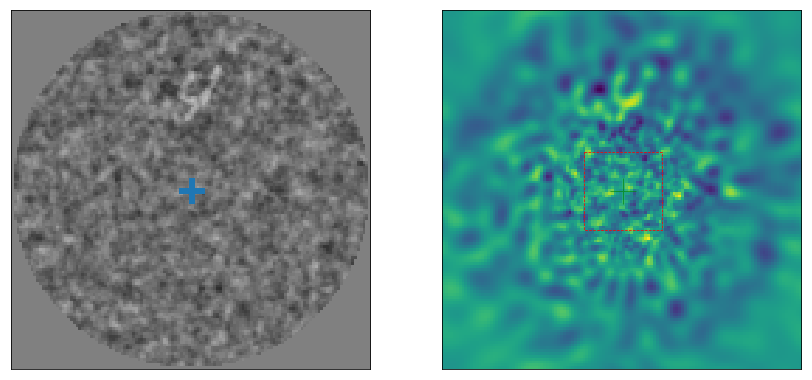

In [6]:
fig, axs = plt.subplots(1, 2, figsize = (figwidth, figwidth/2))
#axs[0].imshow(data_fullfield, cmap=plt.gray(), vmin=0, vmax=1)
axs[0] = d.show(axs[0], data_fullfield)
#axs[1].imshow((retina_inverse_transform @ data_retina).reshape(N_pic, N_pic), cmap=plt.viridis())# vmin=0, vmax=1, 
axs[1] = r.show(axs[1], im)

## Representation of output accuracy (colliculus)

In [7]:
path = "../data/MNIST_accuracy.npy"
import os
if os.path.isfile(path):
    accuracy_map =  np.load(path)
    if args.verbose:
        print('Loading accuracy... min, max=', accuracy_map.min(), accuracy_map.max())
else:
    print('No accuracy data found.')

Loading accuracy... min, max= 0.0145 0.9852


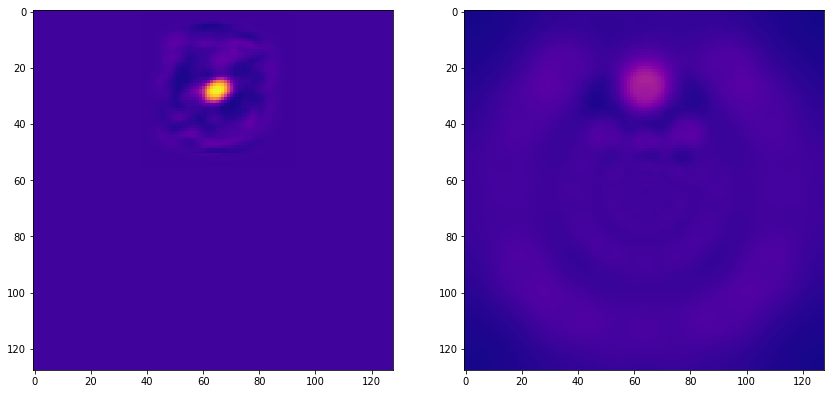

In [8]:
accuracy_colliculus, accuracy_fullfield_map = r.accuracy_fullfield(accuracy_map, i_offset, j_offset)

fig, axs = plt.subplots(1, 2, figsize = (figwidth, figwidth/2))
axs[0].imshow(accuracy_fullfield_map, vmin=0, vmax=1, cmap=plt.plasma())
axs[1].imshow(r.accuracy_invert(accuracy_colliculus), vmin=0, vmax=1, cmap=plt.plasma())


# Network

In [9]:
from where import Net
net = Net(args)

In [10]:
from where import Where
where = Where(args, d, r)

#### Training

In [11]:
import time
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim


In [12]:
def accuracy_gain(prediction, accuracy_colliculus, batch_size, full_fixmap=None):
    """
    Actuate the predictions of the ``where'' pathway to compute final accuracy using the ``what'' pathway
    
    """
    acc = []
    
    for i in range(batch_size):
        fixmap_coll =  accuracy_colliculus[i, :].data.numpy()
        pred_coll = F.sigmoid(prediction[i, :]).data.numpy()
                
        pred_coll_2D = pred_coll.reshape((args.N_azimuth, args.N_eccentricity))
        indices_ij = np.where(pred_coll_2D == max(pred_coll_2D.flatten()))
        azimuth = indices_ij[0][0]
        eccentricity = indices_ij[1][0]
        full_pred = r.colliculus[azimuth,eccentricity,:] #> 0.0003
        
        if full_fixmap is not None:
            full_ref = full_fixmap[i,:]
        else:
            full_ref = r.colliculus_inverse @ fixmap_coll.flatten()
            
        indice_max_full = np.where(full_pred == max(full_pred))[0][0]
        acc_full = full_ref[indice_max_full]     
        acc += [acc_full]
            
    acc_mean = np.mean(acc) #accuracy_colliculus.data.numpy()[:,indices_max])
    return acc_mean, acc

In [19]:
def train(net, minibatch_size,
          optimizer=where.optimizer,
          vsize = args.N_theta * args.N_azimuth * args.N_eccentricity * args.N_phase,
          asize = 1):
    
    t_start = time.time()
    
    if args.verbose: print('Starting training...')
    
    for batch_idx, (data, label) in enumerate(d.loader_train):
        optimizer.zero_grad()

        retina_data = np.zeros((args.minibatch_size, args.N_phase * args.N_theta * args.N_azimuth * args.N_eccentricity))
        accuracy_colliculus = np.zeros((args.minibatch_size, args.N_azimuth * args.N_eccentricity))

        for i in range(minibatch_size):
            data_fullfield, i_offset, j_offset = d.draw(data[i, 0, :, :].numpy())
            retina_data[i, :]  =  r.retina(data_fullfield)
            accuracy_colliculus[i,:], _ = r.accuracy_fullfield(accuracy_map, i_offset, j_offset)
            
        retina_data = Variable(torch.FloatTensor(retina_data))
        accuracy_colliculus = Variable(torch.FloatTensor(accuracy_colliculus))
        
        prediction = net(retina_data)
        loss = args.loss_func(prediction, accuracy_colliculus)
        loss.backward()
        optimizer.step()

        if args.verbose and batch_idx % args.log_interval == 0:
            acc, _ = accuracy_gain(prediction, accuracy_colliculus, minibatch_size)
            print('[%d/%d] Loss: %.3f Acc : %.3f'%(batch_idx*minibatch_size, len(d.loader_train.dataset),loss.data.numpy(), acc))
            f = open(filename_train.replace('npy', 'txt'), 'a')
            f.write('%.5f\t%.5f'%(loss, acc))    
            f.close()
    return net


In [20]:
def test(net, optimizer=where.optimizer,
         vsize=args.N_theta*args.N_azimuth*args.N_eccentricity*args.N_phase,
         asize=args.N_azimuth*args.N_eccentricity):
    
    data, label = next(iter(d.loader_test))
    batch_size = label.shape[0]

    retina_data = np.zeros((batch_size, args.N_phase * args.N_theta * args.N_azimuth * args.N_eccentricity))
    fixmap_data = np.zeros((batch_size, args.N_azimuth * args.N_eccentricity))

    for i in range(batch_size):
            data_fullfield, i_offset, j_offset = d.draw(data[i, 0, :, :].numpy())
            retina_data[i, :]  =  r.retina(data_fullfield)
            accuracy_colliculus[i,:], _ = r.accuracy_fullfield(accuracy_map, i_offset, j_offset)
            
    retina_data = Variable(torch.FloatTensor(retina_data))
    accuracy_colliculus = Variable(torch.FloatTensor(accuracy_colliculus))
    
    with torch.no_grad():
        output = net(retina_data)
        acc, _ = accuracy_gain(output, accuracy_colliculus, batch_size)

    return acc


## Anywhere target, with noise

#### Additive noise + whitening

In [ ]:
filename_train = '../data/2019-03-11_CNS.npy'
filename_train = args.filename + '_train.npy'
if not os.path.isfile(filename_train):
    for epoch in range(args.n_epochs):
        train(net, args.minibatch_size)
        loss = test(net)
        print('Test set: Final Loss: %.3f'%loss) 
    torch.save(net, filename_train)
else:
    net = torch.load(filename_train)       

Starting training...
[0/60000] Loss: 0.692 Acc : 0.122
[10/60000] Loss: 0.689 Acc : 0.221
[20/60000] Loss: 0.692 Acc : 0.100
[30/60000] Loss: 0.692 Acc : 0.140
[40/60000] Loss: 0.692 Acc : 0.101
[50/60000] Loss: 0.689 Acc : 0.106
[60/60000] Loss: 0.691 Acc : 0.105
[70/60000] Loss: 0.694 Acc : 0.100
[80/60000] Loss: 0.691 Acc : 0.104
[90/60000] Loss: 0.691 Acc : 0.100
[100/60000] Loss: 0.694 Acc : 0.098
[110/60000] Loss: 0.692 Acc : 0.100
[120/60000] Loss: 0.692 Acc : 0.110
[130/60000] Loss: 0.691 Acc : 0.771
[140/60000] Loss: 0.688 Acc : 0.100
[150/60000] Loss: 0.694 Acc : 0.116
[160/60000] Loss: 0.689 Acc : 0.121
[170/60000] Loss: 0.692 Acc : 0.120
[180/60000] Loss: 0.689 Acc : 0.140
[190/60000] Loss: 0.694 Acc : 0.112
[200/60000] Loss: 0.694 Acc : 0.118
[210/60000] Loss: 0.694 Acc : 0.163
[220/60000] Loss: 0.690 Acc : 0.101
[230/60000] Loss: 0.691 Acc : 0.104
[240/60000] Loss: 0.690 Acc : 0.099
[250/60000] Loss: 0.690 Acc : 0.137
[260/60000] Loss: 0.692 Acc : 0.106
[270/60000] Loss: 

# Visualisation of some examples

In [18]:
vsize = args.N_theta*args.N_azimuth*args.N_eccentricity*args.N_phase
asize = args.N_azimuth*args.N_eccentricity
data, label = next(iter(d.loader_test))

In [ ]:
args.test_batch_size, 1, vsize

In [ ]:
input_n = np.zeros((args.test_batch_size, 1, vsize))
a_data_n = np.zeros((args.test_batch_size, 1, asize))
full_data = np.zeros((args.test_batch_size, args.N_pic, args.N_pic))
full_fixmap_n = np.zeros((args.test_batch_size, args.N_pic, args.N_pic))

for idx in range(args.test_batch_size):

    data_fullfield, i_offset, j_offset = d.draw(data[idx, 0, :, :].numpy())
    input_n[idx, 0, :]  =  r.retina(data_fullfield)
    a_data_n[idx, 0, :], _ = r.accuracy_fullfield(accuracy_map, i_offset, j_offset)


In [ ]:
for idx in range(30, 35):
    fig = plt.figure(figsize = (15, 8))
    
    ax = fig.add_subplot(141)
    ax.imshow(data[idx, 0, :, :].numpy(), cmap=plt.gray())

    ax = fig.add_subplot(142)
    ax.imshow(r.retina_invert(input_n[idx, 0, :]), cmap=plt.viridis())
    ax.plot(63.5, 63.5, 'r+')
    ax.set_title(idx)
              
    ax = fig.add_subplot(143, projection='polar')
    #col = colliculus_inverse @ a_data_n[idx,0,:]
    vec_t = Variable(torch.FloatTensor(a_data_n[idx, 0, :]))
    vec_t = vec_t.reshape((1, args.N_azimuth * args.N_eccentricity))
    ax.pcolor(r.theta, r.log_r, vec_t.reshape((args.N_azimuth, args.N_eccentricity)), cmap=plt.plasma())
    in_t = Variable(torch.FloatTensor(input_n[idx,0,:]))
    out_t = net(in_t)
    out_sig = F.sigmoid(out_t).detach().numpy()
    out_t = out_t.reshape((1, args.N_azimuth * args.N_eccentricity))
    acc, _ = accuracy_gain(out_t, vec_t, 1, full_fixmap = full_fixmap_n[idx, :].reshape((1, -1)))
    view = r.colliculus_inverse @ out_sig.flatten()

    ax = fig.add_subplot(144, projection='polar')
    ax.pcolor(r.theta, r.log_r, out_sig.reshape((args.N_azimuth, args.N_eccentricity)), cmap=plt.plasma())
                                 

In [ ]:
def test_eccentricities(N_eccentricities=9):
    vsize = args.N_theta*args.N_azimuth*args.N_eccentricity*args.N_phase
    asize = args.N_azimuth*args.N_eccentricity
    
    N_pic_mnist = 28
    N_class_mnist = 10

    test_batch_size = 1000
    
    mem_acc_log = []
    mem_acc_data_log = []
    mem_ref_log = [] 
    mem_ref_data_log = []

    ecc_max=.8
    r_pix = []

    eccentricities = range(N_eccentricities)
    for i_eccentricity in eccentricities:

        eccentricity = ecc_max * (1/args.rho)**(args.N_eccentricity - i_eccentricity)

        radius = args.N_pic / 2 * eccentricity
        print('at scale ', i_eccentricity, ' radius=', radius)
        r_pix.append(radius)

        data, label = next(iter(d.loader_test))

        input_n = np.zeros((args.test_batch_size, 1, vsize))
        a_data = np.zeros((args.test_batch_size, asize))
        full_fixmap_n = np.zeros((args.test_batch_size, args.N_pic**2))

        ref_data = np.zeros(test_batch_size)

        for idx in range(test_batch_size):
            theta = np.random.rand() * 2 * np.pi
            i_offset = int(radius * np.cos(theta))
            j_offset = int(radius * np.sin(theta))

            # changed
            data_fullfield = d.place_object(data[idx, 0, :, :].numpy(), i_offset, j_offset)
            input_n[idx, 0, :]  =  r.retina(data_fullfield)

            a_data[idx, :], accuracy_fullfield_map = r.accuracy_fullfield(accuracy_map, i_offset, j_offset)
            full_fixmap_n[idx, :] = accuracy_fullfield_map.flatten()

            # when we do not do a saccade, the reference accurracy data is pre-computed 
            if radius <= N_pic_mnist:
                ref_data[idx] = accuracy_map[N_pic_mnist - 1 + i_offset, N_pic_mnist - 1 + j_offset]
            else:
                ref_data[idx] = 1 / N_class_mnist      


        in_t = Variable(torch.FloatTensor(input_n))
        out_t = net(in_t)
        a_data_t = Variable(torch.FloatTensor(a_data))
        acc, acc_data = accuracy_gain(out_t, a_data_t, test_batch_size, full_fixmap=full_fixmap_n)
        mem_acc_log += [acc]
        mem_acc_data_log += [acc_data]

        mem_ref_log += [np.mean(ref_data)]
    return r_pix, mem_acc_log, mem_ref_log

N_eccentricities = 9
r_pix, mem_acc_log, mem_ref_log = test_eccentricities(N_eccentricities)

In [ ]:
idx = 30
w = 28
in_t = Variable(torch.FloatTensor(input_n[idx,0,:]))
out_t = net(in_t)
out_sig = F.sigmoid(out_t).detach().numpy()

test = out_sig.reshape((args.N_azimuth, args.N_eccentricity))
indices_ij = np.where(test == max(test.flatten()))
azimuth = indices_ij[0][0]
eccentricity = indices_ij[1][0]
full_masque = r.colliculus[azimuth,eccentricity,:]
indice_move = np.where(full_masque == max(full_masque))
i_move = indice_move[0][0] // 128 - 64
j_move = indice_move[0][0] % 128 - 64
print(i_move, j_move)


fig = plt.figure(figsize = (figwidth, figwidth/2.5))#1.618))
ax_A = plt.subplot(1, 4, 1) 
ax_A = r.show(ax_A, r.retina_invert(input_n[idx, 0, :]))

ax_B = plt.subplot(2, 4, 2, projection='polar', autoscale_on=False)
vec_t = Variable(torch.FloatTensor(a_data_n[idx, 0, :]))
vec_t = vec_t.reshape((1, args.N_azimuth * args.N_eccentricity))
ax_B.pcolor(r.theta, r.log_r, vec_t.reshape((args.N_azimuth, args.N_eccentricity)))
ax_B.grid('off')
#ax.set_rgrids('off')
plt.title('True', fontsize = 14)
ax_B.set_yticklabels([])
ax_B.set_xticklabels([])

ax_Bb = plt.subplot(2, 4, 6, projection='polar')
ax_Bb.pcolor(r.theta, r.log_r, out_sig.reshape((args.N_azimuth, args.N_eccentricity)))
ax_Bb.set_title('Predicted', fontsize = 14)
ax_Bb.set_yticklabels([])
ax_Bb.set_xticklabels([])


ax_C = plt.subplot(1, 4, 3)
data_fullfield = d.place_object(data[idx, 0, :, :].numpy(), 0, 0)
input_vector  =  r.retina(data_fullfield)
ax_C = r.show(ax_C, r.retina_invert(input_vector))
ax_A.arrow(64.5, 64.5, j_move, i_move, width=.3, color='r', head_width=4., length_includes_head=True, edgecolor='k')
vec_t = vec_t.reshape((1, args.N_azimuth * args.N_eccentricity))
out_t = out_t.reshape((1, args.N_azimuth * args.N_eccentricity))
acc, _ = accuracy_gain(out_t, vec_t, 1, full_fixmap = full_fixmap_n[idx, :].reshape((1, -1)))

ax_D = plt.subplot(1, 4, 4)
r_ref = r_pix
r_ref = range(9)

ax_D.bar(r_ref, mem_acc_log, alpha = .5, label = 'One saccade')
ax_D.bar(r_ref, mem_ref_log, alpha = .5, label = 'No saccade') #accuracy_map[27,27:55])
ax_D.plot(np.arange(10)-.5, [0.1]*10, ':', c='k', label = 'Baseline')
plt.legend(loc='best')
ax_D.set_title('Class accuracy', fontsize = 14)
ax_D.set_xlabel('Target eccentricity (pixels)', fontsize = 12)
ax_D.set_xticks(range(9))
ax_D.set_xticklabels(['%.1f' % d for  d in r_pix])
ax_D.set_ylim([0,1])

for ax, text in [[ax_A, 'DIS'], [ax_C, 'SAC']]:
    ax.text(4, 15, text, fontsize=24,
          bbox={'facecolor':'white','alpha':1,'edgecolor':'none','pad':1},
          ha='left', va='center') 

offset = -.015
for ax, text, x_offset, y_offset in [[ax_A, 'A', offset, 1.15], [ax_B, 'B', -.25, 1.225], [ax_C, 'C', offset, 1.15], [ax_D, 'D', offset, 1.15]]:
    ax.text(x_offset, y_offset, '(' + text + ')', fontsize=24,
              bbox={'facecolor':'white','alpha':1,'edgecolor':'none','pad':1},
              ha='left', va='center', transform=ax.transAxes) 

# pos : [left, bottom, width, height] =    The new position of the in `.Figure` coordinates.    
plt.tight_layout()
ax_A.set_position([0.025, 0.1, .3, .45])
ax_B.set_position( [0.24, 0.375, .2, 0.2])
ax_Bb.set_position([0.24, 0.1, .2, 0.2])
ax_C.set_position([0.35, .1, .3, .45])
ax_D.set_position([0.65, .1, .3, .45])
fig.savefig(figname + '.pdf', bbox_inches='tight', pad_inches=0.1)

# post-processing

In [ ]:
!convert  -density {dpi_export} {figname}.pdf {figname}.jpg
!convert  -density {dpi_export} {figname}.pdf {figname}.png
#!convert  -density {dpi_export} -resize 5400  -units pixelsperinch -flatten  -compress lzw  -depth 8 {fname}.pdf {fname}.tiff

In [ ]:
from IPython.display import Image
Image('{figname}.png'.format(figname=figname))

In [ ]:
!ls  -l {figname}*

## Version used

In [ ]:
%load_ext version_information
%version_information numpy, shl_scripts